In [2]:
# load packages
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import sklearn

%matplotlib inline

import pandas
import pickle
import pydot

Using TensorFlow backend.
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framewo

In [22]:
# import the data
data = pandas.read_pickle('raw_processed.pkl')
datav2 = np.load('data_nadj4_stdTrue.npy')
dataLabels = np.load('labels_nadj4_stdTrue.npy')

# format the labels
temp = np.zeros((len(dataLabels),1))
temp[:,0] = dataLabels
dataLabels = temp

# make a short version for better viewing
dataShort = data.iloc[0:10,19:46].copy()

In [27]:

#data.closest_pos.hist()

In [6]:
# NO LONGER NEED TO RUN THIS BECAUSE iAN MADE A DATA PROCESSING SCRIPT
# set the number of adjacent soundings to use
adSoundings=1;

# get the line numbers, find the time difference between adjacent rows, and set a threshold for two points to be considered 
# part of the same sounding
lineNumbers=np.unique(data["LINE_NO"])
timeDiff=np.diff(data["TIMESTAMP"])
timeDiffMask=timeDiff<5e-6

# iterate through the line numbers
for line in lineNumbers:
    
# this is for debugging
#if 1==1:
#    line=lineNumbers[0]

    # make a mask for the rows in the big DF that are for this line number
    rowIndex=data["LINE_NO"]==line
    
    # get just the current rows
    currData=data.loc[rowIndex,:]
    currData.reset_index(drop=True, inplace=True)
    
    # make an array of the time differences
    timeDiff=np.diff(currData["TIMESTAMP"])

    # if the first time difference is large, drop the first row, this throws a warning
    if timeDiff[0]>1e-5:
        currData.drop([0], inplace=True)
        currData.reset_index(drop=True, inplace=True)
    
    # set the number of pairs in this line and make some arrays with large numbers for the HM and LM data
    numberPairs=np.int(len(currData.index)/2)
    currDataLM=np.ones((numberPairs,1+adSoundings*2,37))*9000
    currDataHM=np.ones((numberPairs,1+adSoundings*2,37))*9000
    currLabelsLM=np.zeros((numberPairs,1))
    currLabelsHM=np.zeros((numberPairs,1))
    
    # check to see if the first row is LM or HM, set the indexing
    if np.mean(currData.loc[0,'DBDT_Ch1GT1':'DBDT_Ch1GT28'])>9990:
        hmFirst=1
    else:
        hmFirst=0
               
    # iterate through the number of pairs
    for i in range(numberPairs):
        if hmFirst==1:
            if adSoundings==1:
                hmIndex=[(i-1)*2,i*2,(i+1)*2]
                lmIndex=[(i-1)*2+1,i*2+1,(i+1)*2+1]
            elif adSoundings==2:
                hmIndex=[(i-2)*2,(i-1)*2,i*2,(i+1)*2,(i+2)*2]
                lmIndex=[(i-2)*2+1,(i-1)*2+1,i*2+1,(i+1)*2+1,(i+2)*2+1]
        else:
            if adSoundings==1:
                lmIndex=[(i-1)*2,i*2,(i+1)*2]
                hmIndex=[(i-1)*2+1,i*2+1,(i+1)*2+1]
            elif adSoundings==2:
                hmIndex=[(i-2)*2,(i-1)*2,i*2,(i+1)*2,(i+2)*2]
                lmIndex=[(i-2)*2+1,(i-1)*2+1,i*2+1,(i+1)*2+1,(i+2)*2+1]
        
        # for the first pair, leave the sounding in position 0 alone as it doesnt exist, do the same for the last pair but 
        # for the sounding in position 2
        # TODO: modify this to work for 2 or 3 or 4 or 5 adjacent soundings
        if i==0:
            currDataLM[i,2,0:28]=currData.loc[lmIndex[2],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataHM[i,2,:]=currData.loc[hmIndex[2],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
        elif i==numberPairs-1:
            currDataLM[i,0,0:28]=currData.loc[lmIndex[0],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataHM[i,0,:]=currData.loc[hmIndex[0],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
            
        # for every other pair fill in both adjacent soundings
        # TODO: modify this to work for 2 or 3 or 4 or 5 adjacent soundings
        else:
            currDataLM[i,0,0:28]=currData.loc[lmIndex[0],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataLM[i,2,0:28]=currData.loc[lmIndex[2],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataHM[i,0,:]=currData.loc[hmIndex[0],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
            currDataHM[i,2,:]=currData.loc[hmIndex[2],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
            
        # middle sounding and labels always get set for every pair
        currDataLM[i,1,0:28]=currData.loc[lmIndex[1],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
        currDataHM[i,1,:]=currData.loc[hmIndex[1],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
        currLabelsLM[i,0]=currData.loc[i*2+1,'VALID']
        currLabelsHM[i,0]=currData.loc[i*2,'VALID']
    
    # set large values to mean of other values
    for k in range(0,37):
        
        # get the current timegate
        tempDataHM=currDataHM[:,:,k]
        
        # set values over 5000 to the mean of the timegate
        tempDataHM[np.abs(tempDataHM)>5000]=np.mean(tempDataHM[np.abs(tempDataHM)<5000])
        
        # do the same to nans
        tempDataHM=np.nan_to_num(tempDataHM, nan=np.mean(tempDataHM[np.abs(tempDataHM)<5000]))
        
        # check to see if it fucking worked
        if np.isnan(tempDataHM).any():
            print("wtf")
        currDataHM[:,:,k]=tempDataHM
        
        # do the same thing but for the LM
        tempDataLM=currDataLM[:,:,k]
        tempDataLM[np.abs(tempDataLM)>5000]=np.mean(tempDataLM[np.abs(tempDataLM)<5000])
        
        # doesnt work, will deal with the nans below
        tempDataLM=np.nan_to_num(tempDataLM, nan=np.mean(tempDataLM[np.abs(tempDataLM)<5000]))
        #if np.isnan(tempDataLM).any():
        #    print("wtf LM",np.mean(tempDataLM[np.abs(tempDataLM)<5000]))
        currDataLM[:,:,k]=tempDataLM

    # now build one array with everything, if its the first line make it, otherwise append
    if line==lineNumbers[0]:
        dataLM=currDataLM
        dataHM=currDataHM
        labelsLM=currLabelsLM
        labelsHM=currLabelsHM
    else:
        dataLM=np.append(dataLM,currDataLM, axis=0)
        dataHM=np.append(dataHM,currDataHM, axis=0)
        labelsLM=np.append(labelsLM,currLabelsLM, axis=0)
        labelsHM=np.append(labelsHM,currLabelsHM, axis=0)

# drop rows where the lm and hm labels dont agree
indexGood=labelsHM==labelsLM

# see how many locations this happened in
print(np.sum(np.abs(labelsLM-labelsHM)))

# keep only the rows where they agree
dataLM=dataLM[indexGood[:,0],:,:]
dataHM=dataHM[indexGood[:,0],:,:]
labelsLM=labelsLM[indexGood[:,0],:]
labelsHM=labelsHM[indexGood[:,0],:]

D:\Anaconda3\envs\dlwin36v2\lib\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in less


235.0


In [8]:
# remove the locations where the labels dont agree
#datav2=datav2[indexGood[:,0],:,:,:]
data_preped=np.transpose(datav2, (0, 2, 3, 1))

# set large values to mean of other values
for k in range(0,37):
    for m in range(0,4):
        # get the current timegate
        currData=data_preped[:,:,k,m]

        # set values over 5000 to the mean of the timegate
        currData[np.abs(currData)>5000]=np.mean(currData[np.abs(currData)<5000])

        # do the same to nans
        currData=np.nan_to_num(currData, nan=np.mean(currData[np.abs(currData)<5000]))

        # put it back
        data_preped[:,:,k,m]=currData

D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


ValueError: max must be larger than min in range parameter.

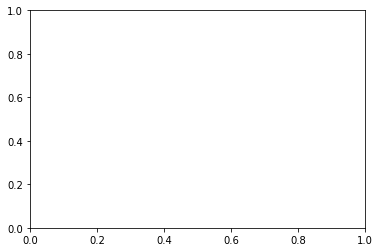

In [20]:
plt.hist(data_preped[:,4,28,1])

In [28]:
# make X from the HM and LM data, X is m (examples) by 3 (first adjacent sounding, middle sounding, other adjacent sounding) 
# by 37 (timegates) by 2 (low moment then high moment)
X=np.zeros([np.shape(dataLM)[0],np.shape(dataLM)[1],np.shape(dataLM)[2],2])
X[:,:,:,0]=dataLM
X[:,:,:,1]=dataHM

X=data_preped

# set nans to 0 (there shouldnt be any but who knows)
X=np.nan_to_num(X)

# scale each timegate to be between -1 and 1
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in range(np.shape(X)[-1]):
    for j in range(np.shape(X)[1]):
        
        # do it for all examples, for this moment
        X[:,j,:,i] = min_max_scaler.fit_transform(X[:,j,:,i])
        
        # for the timegates where the LM never exists, set it back to 0 so it sits in the middle of the scaled range
        for k in range(np.shape(X)[2]):
            if i==1 or i==3:
                if k>=28:
                    X[:,j,k,i]=X[:,j,k,i]-X[:,j,k,i]

# make some random indices, then take 20000 examples for training and the rest for test, results in about 85/15 split
indices=np.random.permutation(X.shape[0])
X_train=X[indices[:20000],:,:,:]
X_test=X[indices[20000:],:,:,:]
Y_train=dataLabels[indices[:20000],:]
Y_test=dataLabels[indices[20000:],:]

# print out some shit
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 20000
number of test examples = 3987
X_train shape: (20000, 9, 37, 4)
Y_train shape: (20000, 1)
X_test shape: (3987, 9, 37, 4)
Y_test shape: (3987, 1)


(array([  11.,   13.,   78.,  247.,  636., 1778., 5079., 8852., 5987.,
        1079.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

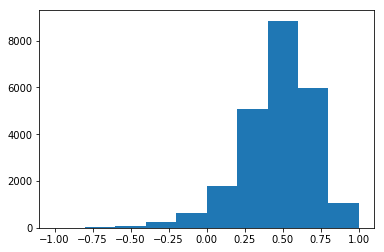

In [8]:
# look at a timegate to check the scaling
plt.hist(X[:,1,3,0].flatten())

In [30]:
def model(input_shape):

    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """

    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    #X = ZeroPadding2D((3, 3))(X_input)
    
    # initializer to use
    initToUse=keras.initializers.glorot_normal(seed=0)
    #initToUse=keras.initializers.he_normal(seed=0)
    
    # for the leakly relu
    alphaParam=0.3

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (2, 3), strides = (1, 1), kernel_initializer=initToUse, name = 'conv0', padding='same')(X_input)
    X = MaxPooling2D((1, 2), name='max_pool0')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(32, (2, 5), strides = (1, 1), kernel_initializer=initToUse, name = 'conv1', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool1')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(64, (2, 7), strides = (1, 1), kernel_initializer=initToUse, name = 'conv2', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool2')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(128, (2, 9), strides = (1, 1), kernel_initializer=initToUse, name = 'conv3', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool3')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(128, (2, 11), strides = (1, 1), kernel_initializer=initToUse, name = 'conv4', padding='same')(X)
    #X = MaxPooling2D((1, 2), name='max_pool3')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool_final')(X)
    
    # make another initializer
    initToUse2=keras.initializers.he_normal(seed=0)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(200, activation='relu', kernel_initializer=initToUse2,name='fc0')(X)
    X = Dense(100, activation='relu', kernel_initializer=initToUse2,name='fc1')(X)
    X = Dense(50, activation='relu', kernel_initializer=initToUse2,name='fc2')(X)
    X = Dense(1, activation='sigmoid', kernel_initializer=initToUse,name='fc3')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    ### END CODE HERE ###
    
    return model

In [77]:
def modelv2(inputShape,L2param):

    model = keras.models.Sequential()
    
    # make the initializer
    initToUse=keras.initializers.glorot_normal(seed=1)
    initToUse2=keras.initializers.he_normal(seed=1)

    # for the leakly relu
    alphaParam=0.3
    
    # short dim
    shortDim=3
    
    # add some regularization to the dense layers
    denseReg=keras.regularizers.l2(L2param)
    
    # add some conv layers
    model.add(Conv2D(16, (shortDim, 3), input_shape=inputShape, kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(32, (shortDim, 5), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(64, (shortDim, 7), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (shortDim, 9), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(256, (shortDim, 11), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    # flatten and do some dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=denseReg)) 
    model.add(Dense(160, activation='relu', kernel_regularizer=denseReg))
    model.add(Dense(96, activation='relu', kernel_regularizer=denseReg))
    model.add(Dense(32, activation='relu', kernel_regularizer=denseReg))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
def trainEnsemble(modelType,ensembleSize,X_train,learingRate,epochNum,l2param,batchSize,trialEpochNum,verbFlag):
    
    # make a list of models and other lists and arrays we need
    test_acc_var=[]
    test_acc_mean=[]
    test_acc=np.zeros((ensembleSize,1))
    Models=[]
    adam=keras.optimizers.Adam(beta_1=0.9, beta_2=0.999,lr=learningRate)
    
    # train the ensemble of models
    for i in range(ensembleSize):
        
        # make the flag for checking if the training got stuck
        whileFlag=1
        while whileFlag==1:

            # make the model based on the model type
            if modelType==1:
                tempModel = modelv2(X_train.shape[1:],l2param)

            # compile the model
            tempModel.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])

            # fit the model
            tempModel.fit(x = X_train, y = Y_train, epochs = trialEpochNum, batch_size = batchSize,  verbose=verbFlag)

            # test to see if it was stuck
            temp=tempModel.evaluate(x = X_train, y = Y_train)

            if (temp[1]*100)>73:

                # train for all the epochs
                tempModel.fit(x = X_train, y = Y_train, epochs = epochNum, batch_size = batchSize,  verbose=verbFlag)

                # predict and store the results
                temp=tempModel.evaluate(x = X_test, y = Y_test)
                test_acc[i]=temp[1]

                # append the model and end the while loop
                Models.append(tempModel)
                whileFlag=0

    test_acc_var.append(np.var(100*test_acc[:]))

    # get the mean label, round it and find the emsemble test acc
    meanLabels=(Models[0].predict(X_test)+Models[1].predict(X_test)+Models[2].predict(X_test)+Models[3].predict(X_test)+Models[4].predict(X_test))/5
    meanLabels=np.round(meanLabels)
    wrongLabels=Y_test-meanLabels
    test_acc_mean.append(1-np.sum(np.abs(wrongLabels))/len(Y_test))

    print("\n Final ensemble test accuracy of: ",str(np.round(test_acc_mean[m]*100,2)),", mean test accuracy of:",np.str(np.round(np.mean(test_acc[:,m])*100,2)),"with a std of: ",str(np.round(test_acc_var[m],2)))

    return Models, test_acc_mean, test_acc_var, test_acc

In [65]:
# set epochs and everything
learningRate=0.0008
epochNum=300
#epochNum=100   # using shorter for faster training
batchSize=480  # best was 475 but 480 is a multiple of 32, fits in memory better?

adam=keras.optimizers.Adam(beta_1=0.9, beta_2=0.999,lr=learningRate)
Model1 = modelv2(X_train.shape[1:] )
Model1.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])
Model1.fit(x = X_train, y = Y_train, epochs = epochNum, batch_size = batchSize,  verbose=1)
Model1.evaluate(x = X_test, y = Y_test)


Epoch 1/300
20000/20000 [==============================] - 2s - loss: 5.1073 - acc: 0.7072     
Epoch 2/300
20000/20000 [==============================] - 1s - loss: 1.8838 - acc: 0.7361     
Epoch 3/300
20000/20000 [==============================] - 1s - loss: 1.1318 - acc: 0.7393     
Epoch 4/300
20000/20000 [==============================] - 1s - loss: 0.8252 - acc: 0.7478     
Epoch 5/300
20000/20000 [==============================] - 1s - loss: 0.6874 - acc: 0.7493     
Epoch 6/300
20000/20000 [==============================] - 1s - loss: 0.6239 - acc: 0.7499     
Epoch 7/300
20000/20000 [==============================] - 1s - loss: 0.5965 - acc: 0.7487     
Epoch 8/300
20000/20000 [==============================] - 1s - loss: 0.5809 - acc: 0.7506     
Epoch 9/300
20000/20000 [==============================] - 1s - loss: 0.5680 - acc: 0.7504     
Epoch 10/300
20000/20000 [==============================] - 1s - loss: 0.5598 - acc: 0.7543     
Epoch 11/300
20000/20000 [=============

20000/20000 [==============================] - 1s - loss: 0.3431 - acc: 0.8629     
Epoch 85/300
20000/20000 [==============================] - 1s - loss: 0.3472 - acc: 0.8593     
Epoch 86/300
20000/20000 [==============================] - 1s - loss: 0.3583 - acc: 0.8535     
Epoch 87/300
20000/20000 [==============================] - 1s - loss: 0.3588 - acc: 0.8555     
Epoch 88/300
20000/20000 [==============================] - 1s - loss: 0.3669 - acc: 0.8515     
Epoch 89/300
20000/20000 [==============================] - 1s - loss: 0.3662 - acc: 0.8519     
Epoch 90/300
20000/20000 [==============================] - 1s - loss: 0.3470 - acc: 0.8602     
Epoch 91/300
20000/20000 [==============================] - 1s - loss: 0.3395 - acc: 0.8642     
Epoch 92/300
20000/20000 [==============================] - 1s - loss: 0.3480 - acc: 0.8581     
Epoch 93/300
20000/20000 [==============================] - 2s - loss: 0.3380 - acc: 0.8666     
Epoch 94/300
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.2495 - acc: 0.9037     
Epoch 168/300
20000/20000 [==============================] - 1s - loss: 0.2352 - acc: 0.9095     
Epoch 169/300
20000/20000 [==============================] - 1s - loss: 0.2387 - acc: 0.9077     
Epoch 170/300
20000/20000 [==============================] - 1s - loss: 0.2453 - acc: 0.9052     
Epoch 171/300
20000/20000 [==============================] - 1s - loss: 0.2388 - acc: 0.9065     - ETA: 1s - loss: 0.2469
Epoch 172/300
20000/20000 [==============================] - 1s - loss: 0.2584 - acc: 0.9002     
Epoch 173/300
20000/20000 [==============================] - 1s - loss: 0.2345 - acc: 0.9114     - ETA: 1s - loss: 0.2411 -
Epoch 174/300
20000/20000 [==============================] - 1s - loss: 0.2269 - acc: 0.9150     
Epoch 175/300
20000/20000 [==============================] - 1s - loss: 0.2275 - acc: 0.9128     
Epoch 176/300
20000/20000 [==============================] - 1s - loss: 0.2404 - a

20000/20000 [==============================] - 1s - loss: 0.1752 - acc: 0.9385     
Epoch 250/300
20000/20000 [==============================] - 1s - loss: 0.3798 - acc: 0.8489     
Epoch 251/300
20000/20000 [==============================] - 1s - loss: 0.3531 - acc: 0.8591     
Epoch 252/300
20000/20000 [==============================] - 1s - loss: 0.2523 - acc: 0.9029     
Epoch 253/300
20000/20000 [==============================] - 1s - loss: 0.2295 - acc: 0.9180     
Epoch 254/300
20000/20000 [==============================] - 1s - loss: 0.1760 - acc: 0.9392     
Epoch 255/300
20000/20000 [==============================] - 1s - loss: 0.1695 - acc: 0.9412     
Epoch 256/300
20000/20000 [==============================] - 1s - loss: 0.1564 - acc: 0.9462     
Epoch 257/300
20000/20000 [==============================] - 1s - loss: 0.1517 - acc: 0.9476     
Epoch 258/300
20000/20000 [==============================] - 1s - loss: 0.1856 - acc: 0.9325     
Epoch 259/300
20000/20000 [=======

[0.26288837717683927, 0.91798344623005]

In [83]:
%%time
# set epochs and everything
l2param=0.001
learningRate=0.0008
epochNum=[100,125,150]
#epochNum=350
#epochNum=100   # using shorter for faster training
batchSize=480  # best was 475 but 480 is a multiple of 32, fits in memory better?
adam=keras.optimizers.Adam(beta_1=0.9, beta_2=0.999,lr=learningRate)


# some models get stuck at 71.x%, use a while loop and some number of trial epochs to see if its stuck or not
trialEpochNum=20
accThreshold=73

# make a list of models and other lists and arrays we need
trialsToRun=3
ensembleSize=5
test_acc_var=[]
test_acc_mean=[]
test_acc=np.zeros((ensembleSize,trialsToRun))

for m in range(trialsToRun):
    # train the ensemble of models
    Models=[]
    for i in range(ensembleSize):
        whileFlag=1

        while whileFlag==1:

            # make the model
            tempModel = modelv2(X_train.shape[1:],l2param)

            # compile the model
            tempModel.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])

            # fit the model
            tempModel.fit(x = X_train, y = Y_train, epochs = trialEpochNum, batch_size = batchSize,  verbose=0)

            # test to see if it was stuck
            temp=tempModel.evaluate(x = X_train, y = Y_train)

            if (temp[1]*100)>accThreshold:

                # train for all the epochs
                tempModel.fit(x = X_train, y = Y_train, epochs = epochNum[m], batch_size = batchSize,  verbose=1)

                # predict and store the results
                temp=tempModel.evaluate(x = X_test, y = Y_test)
                test_acc[i,m]=temp[1]
                currTestAcc=temp[1]

                # append the model and end the while loop
                Models.append(tempModel)
                whileFlag=0

    test_acc_var.append(np.var(100*test_acc[:,m]))

    # get the mean label, round it and find the emsemble test acc
    meanLabels=(Models[0].predict(X_test)+Models[1].predict(X_test)+Models[2].predict(X_test)+Models[3].predict(X_test)+Models[4].predict(X_test))/5
    meanLabels=np.round(meanLabels)
    wrongLabels=Y_test-meanLabels
    test_acc_mean.append(1-np.sum(np.abs(wrongLabels))/len(Y_test))

    print("\n Final ensemble test accuracy of: ",str(np.round(test_acc_mean[m]*100,2)),", mean test accuracy of:",np.str(np.round(np.mean(test_acc[:,m])*100,2)),"with a std of: ",str(np.round(test_acc_var[m],2)))

20000/20000 [==============================] - 2s - loss: 0.5405 - acc: 0.7614     
Epoch 2/100
20000/20000 [==============================] - 1s - loss: 0.5369 - acc: 0.7615     
Epoch 3/100
20000/20000 [==============================] - 1s - loss: 0.5250 - acc: 0.7719     
Epoch 4/100
20000/20000 [==============================] - 1s - loss: 0.5127 - acc: 0.7821     
Epoch 5/100
20000/20000 [==============================] - 1s - loss: 0.5094 - acc: 0.7824     
Epoch 6/100
20000/20000 [==============================] - 2s - loss: 0.5056 - acc: 0.7861     
Epoch 7/100
20000/20000 [==============================] - 1s - loss: 0.5053 - acc: 0.7852     
Epoch 8/100
20000/20000 [==============================] - 1s - loss: 0.4971 - acc: 0.7883     
Epoch 9/100
20000/20000 [==============================] - 1s - loss: 0.5026 - acc: 0.7851     
Epoch 10/100
20000/20000 [==============================] - 1s - loss: 0.4869 - acc: 0.7970     
Epoch 11/100
20000/20000 [=========================

20000/20000 [==============================] - 2s - loss: 0.2694 - acc: 0.8943     
Epoch 85/100
20000/20000 [==============================] - 2s - loss: 0.3021 - acc: 0.8765     
Epoch 86/100
20000/20000 [==============================] - 1s - loss: 0.3009 - acc: 0.8810     
Epoch 87/100
20000/20000 [==============================] - 1s - loss: 0.2640 - acc: 0.8983     
Epoch 88/100
20000/20000 [==============================] - 2s - loss: 0.2542 - acc: 0.9013     
Epoch 89/100
20000/20000 [==============================] - 1s - loss: 0.2562 - acc: 0.9006     
Epoch 90/100
20000/20000 [==============================] - 2s - loss: 0.2625 - acc: 0.8969     
Epoch 91/100
20000/20000 [==============================] - 2s - loss: 0.2500 - acc: 0.9038     
Epoch 92/100
20000/20000 [==============================] - 2s - loss: 0.2457 - acc: 0.9040     
Epoch 93/100
20000/20000 [==============================] - 2s - loss: 0.2393 - acc: 0.9084     
Epoch 94/100
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.5224 - acc: 0.7679     
Epoch 68/100
20000/20000 [==============================] - 1s - loss: 0.5086 - acc: 0.7767     
Epoch 69/100
20000/20000 [==============================] - 1s - loss: 0.4949 - acc: 0.7863     
Epoch 70/100
20000/20000 [==============================] - 2s - loss: 0.4975 - acc: 0.7853     
Epoch 71/100
20000/20000 [==============================] - 1s - loss: 0.4862 - acc: 0.7889     
Epoch 72/100
20000/20000 [==============================] - 2s - loss: 0.4695 - acc: 0.7987     
Epoch 73/100
20000/20000 [==============================] - 1s - loss: 0.4658 - acc: 0.8072     
Epoch 74/100
20000/20000 [==============================] - 1s - loss: 0.4841 - acc: 0.7920     
Epoch 75/100
20000/20000 [==============================] - 1s - loss: 0.4485 - acc: 0.8121     
Epoch 76/100
20000/20000 [==============================] - 1s - loss: 0.4307 - acc: 0.8173     
Epoch 77/100
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.3613 - acc: 0.8531     
Epoch 50/100
20000/20000 [==============================] - 1s - loss: 0.3650 - acc: 0.8506     
Epoch 51/100
20000/20000 [==============================] - 1s - loss: 0.3666 - acc: 0.8469     
Epoch 52/100
20000/20000 [==============================] - 1s - loss: 0.3556 - acc: 0.8560     
Epoch 53/100
20000/20000 [==============================] - 1s - loss: 0.3502 - acc: 0.8570     
Epoch 54/100
20000/20000 [==============================] - 1s - loss: 0.3478 - acc: 0.8592     
Epoch 55/100
20000/20000 [==============================] - 1s - loss: 0.3398 - acc: 0.8602     
Epoch 56/100
20000/20000 [==============================] - 1s - loss: 0.3371 - acc: 0.8625     
Epoch 57/100
20000/20000 [==============================] - 1s - loss: 0.3438 - acc: 0.8619     
Epoch 58/100
20000/20000 [==============================] - 1s - loss: 0.3327 - acc: 0.8666     
Epoch 59/100
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.4686 - acc: 0.8025     
Epoch 33/100
20000/20000 [==============================] - 1s - loss: 0.4725 - acc: 0.8011     
Epoch 34/100
20000/20000 [==============================] - 1s - loss: 0.4690 - acc: 0.8037     
Epoch 35/100
20000/20000 [==============================] - 1s - loss: 0.4814 - acc: 0.7926     
Epoch 36/100
20000/20000 [==============================] - 1s - loss: 0.4670 - acc: 0.8013     
Epoch 37/100
20000/20000 [==============================] - 1s - loss: 0.4586 - acc: 0.8086     
Epoch 38/100
20000/20000 [==============================] - 1s - loss: 0.4620 - acc: 0.8054     
Epoch 39/100
20000/20000 [==============================] - 1s - loss: 0.4581 - acc: 0.8086     
Epoch 40/100
20000/20000 [==============================] - 1s - loss: 0.4560 - acc: 0.8074     
Epoch 41/100
20000/20000 [==============================] - 2s - loss: 0.4653 - acc: 0.8037     
Epoch 42/100
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.5447 - acc: 0.7557     
Epoch 16/100
20000/20000 [==============================] - 1s - loss: 0.5445 - acc: 0.7570     
Epoch 17/100
20000/20000 [==============================] - 1s - loss: 0.5406 - acc: 0.7601     
Epoch 18/100
20000/20000 [==============================] - 1s - loss: 0.5383 - acc: 0.7615     
Epoch 19/100
20000/20000 [==============================] - 1s - loss: 0.5360 - acc: 0.7622     
Epoch 20/100
20000/20000 [==============================] - 1s - loss: 0.5321 - acc: 0.7626     
Epoch 21/100
20000/20000 [==============================] - 2s - loss: 0.5423 - acc: 0.7556     
Epoch 22/100
20000/20000 [==============================] - 1s - loss: 0.5322 - acc: 0.7633     
Epoch 23/100
20000/20000 [==============================] - 2s - loss: 0.5361 - acc: 0.7591     
Epoch 24/100
20000/20000 [==============================] - 1s - loss: 0.5315 - acc: 0.7623     
Epoch 25/100
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.3896 - acc: 0.8393     
Epoch 99/100
20000/20000 [==============================] - 1s - loss: 0.3970 - acc: 0.8334     
Epoch 100/100
3648/3987 [==========================>...] - ETA: 0s
 Final ensemble test accuracy of:  88.46 , mean test accuracy of: 86.41 with a std of:  6.89
20000/20000 [==============================] - 1s - loss: 0.5662 - acc: 0.7492     
Epoch 2/125
20000/20000 [==============================] - 1s - loss: 0.5650 - acc: 0.7493     
Epoch 3/125
20000/20000 [==============================] - 1s - loss: 0.5616 - acc: 0.7515     
Epoch 4/125
20000/20000 [==============================] - 1s - loss: 0.5635 - acc: 0.7495     
Epoch 5/125
20000/20000 [==============================] - 1s - loss: 0.5545 - acc: 0.7563     
Epoch 6/125
20000/20000 [==============================] - 1s - loss: 0.5562 - acc: 0.7538     
Epoch 7/125
20000/20000 [==============================] - 1s - loss: 0.5556 - acc: 0.7535     

20000/20000 [==============================] - 1s - loss: 0.4181 - acc: 0.8248     - ETA: 0s - loss: 0.4178 - acc: 0.
Epoch 79/125
20000/20000 [==============================] - 1s - loss: 0.4060 - acc: 0.8293     
Epoch 80/125
20000/20000 [==============================] - 1s - loss: 0.4039 - acc: 0.8311     
Epoch 81/125
20000/20000 [==============================] - 2s - loss: 0.3977 - acc: 0.8354     
Epoch 82/125
20000/20000 [==============================] - 2s - loss: 0.3888 - acc: 0.8396     
Epoch 83/125
20000/20000 [==============================] - 2s - loss: 0.4790 - acc: 0.7941     
Epoch 84/125
20000/20000 [==============================] - 2s - loss: 0.4622 - acc: 0.8014     
Epoch 85/125
20000/20000 [==============================] - 1s - loss: 0.4242 - acc: 0.8201     - ETA: 0s - loss: 0.4217 - acc: 
Epoch 86/125
20000/20000 [==============================] - 1s - loss: 0.4055 - acc: 0.8256     
Epoch 87/125
20000/20000 [==============================] - 1s - loss: 0.3

20000/20000 [==============================] - 1s - loss: 0.5158 - acc: 0.7732     
Epoch 36/125
20000/20000 [==============================] - 1s - loss: 0.5171 - acc: 0.7703     
Epoch 37/125
20000/20000 [==============================] - 2s - loss: 0.5227 - acc: 0.7665     
Epoch 38/125
20000/20000 [==============================] - 1s - loss: 0.5002 - acc: 0.7835     
Epoch 39/125
20000/20000 [==============================] - 1s - loss: 0.4883 - acc: 0.7923     
Epoch 40/125
20000/20000 [==============================] - 2s - loss: 0.5208 - acc: 0.7713     
Epoch 41/125
20000/20000 [==============================] - 1s - loss: 0.5038 - acc: 0.7829     
Epoch 42/125
20000/20000 [==============================] - 2s - loss: 0.4851 - acc: 0.7925     
Epoch 43/125
20000/20000 [==============================] - 2s - loss: 0.4841 - acc: 0.7914     
Epoch 44/125
20000/20000 [==============================] - 2s - loss: 0.4983 - acc: 0.7857     
Epoch 45/125
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.2635 - acc: 0.8903     
Epoch 119/125
20000/20000 [==============================] - 1s - loss: 0.3183 - acc: 0.8690     
Epoch 120/125
20000/20000 [==============================] - 1s - loss: 0.2648 - acc: 0.8941     
Epoch 121/125
20000/20000 [==============================] - 1s - loss: 0.2695 - acc: 0.8910     
Epoch 122/125
20000/20000 [==============================] - 1s - loss: 0.2653 - acc: 0.8930     
Epoch 123/125
20000/20000 [==============================] - 1s - loss: 0.2388 - acc: 0.9053     - ETA: 1s - loss: 
Epoch 124/125
20000/20000 [==============================] - 1s - loss: 0.2400 - acc: 0.9015     
Epoch 125/125
20000/20000 [==============================] - 1s - loss: 0.5673 - acc: 0.7504     
Epoch 2/125
20000/20000 [==============================] - 1s - loss: 0.5639 - acc: 0.7520     
Epoch 3/125
20000/20000 [==============================] - 2s - loss: 0.5688 - acc: 0.7478     
Epoch 4/125
20000/20

20000/20000 [==============================] - 1s - loss: 0.3927 - acc: 0.8367     
Epoch 76/125
20000/20000 [==============================] - 2s - loss: 0.3783 - acc: 0.8423     
Epoch 77/125
20000/20000 [==============================] - 1s - loss: 0.3698 - acc: 0.8481     
Epoch 78/125
20000/20000 [==============================] - 1s - loss: 0.3997 - acc: 0.8324     
Epoch 79/125
20000/20000 [==============================] - 1s - loss: 0.3792 - acc: 0.8432     
Epoch 80/125
20000/20000 [==============================] - 1s - loss: 0.3777 - acc: 0.8431     
Epoch 81/125
20000/20000 [==============================] - 1s - loss: 0.3649 - acc: 0.8519     
Epoch 82/125
20000/20000 [==============================] - 1s - loss: 0.3698 - acc: 0.8459     
Epoch 83/125
20000/20000 [==============================] - 1s - loss: 0.3587 - acc: 0.8519     
Epoch 84/125
20000/20000 [==============================] - 2s - loss: 0.3560 - acc: 0.8539     
Epoch 85/125
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.5242 - acc: 0.7688     
Epoch 34/125
20000/20000 [==============================] - 1s - loss: 0.5148 - acc: 0.7785     
Epoch 35/125
20000/20000 [==============================] - 1s - loss: 0.5156 - acc: 0.7773     
Epoch 36/125
20000/20000 [==============================] - 1s - loss: 0.5129 - acc: 0.7766     
Epoch 37/125
20000/20000 [==============================] - 1s - loss: 0.5127 - acc: 0.7772     
Epoch 38/125
20000/20000 [==============================] - 1s - loss: 0.5239 - acc: 0.7731     
Epoch 39/125
20000/20000 [==============================] - 1s - loss: 0.5017 - acc: 0.7843     
Epoch 40/125
20000/20000 [==============================] - 1s - loss: 0.5018 - acc: 0.7829     
Epoch 41/125
20000/20000 [==============================] - 1s - loss: 0.5019 - acc: 0.7853     
Epoch 42/125
20000/20000 [==============================] - 1s - loss: 0.4894 - acc: 0.7929     
Epoch 43/125
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.4076 - acc: 0.8295     
Epoch 116/125
20000/20000 [==============================] - 1s - loss: 0.3895 - acc: 0.8358     
Epoch 117/125
20000/20000 [==============================] - 1s - loss: 0.3695 - acc: 0.8450     
Epoch 118/125
20000/20000 [==============================] - 1s - loss: 0.4163 - acc: 0.8258     
Epoch 119/125
20000/20000 [==============================] - 1s - loss: 0.3802 - acc: 0.8411     
Epoch 120/125
20000/20000 [==============================] - 1s - loss: 0.3845 - acc: 0.8392     
Epoch 121/125
20000/20000 [==============================] - 1s - loss: 0.4000 - acc: 0.8318     
Epoch 122/125
20000/20000 [==============================] - 1s - loss: 0.3824 - acc: 0.8387     
Epoch 123/125
20000/20000 [==============================] - 1s - loss: 0.3636 - acc: 0.8488     
Epoch 124/125
20000/20000 [==============================] - 1s - loss: 0.3695 - acc: 0.8458     
Epoch 125/125
20000/20000 [=======

20000/20000 [==============================] - 1s - loss: 0.3640 - acc: 0.8489     
Epoch 74/125
20000/20000 [==============================] - 1s - loss: 0.3582 - acc: 0.8517     
Epoch 75/125
20000/20000 [==============================] - 1s - loss: 0.3604 - acc: 0.8509     
Epoch 76/125
20000/20000 [==============================] - 1s - loss: 0.3630 - acc: 0.8474     
Epoch 77/125
20000/20000 [==============================] - 1s - loss: 0.3512 - acc: 0.8540     
Epoch 78/125
20000/20000 [==============================] - 1s - loss: 0.3408 - acc: 0.8599     
Epoch 79/125
20000/20000 [==============================] - 1s - loss: 0.3461 - acc: 0.8571     
Epoch 80/125
20000/20000 [==============================] - 1s - loss: 0.3401 - acc: 0.8613     
Epoch 81/125
20000/20000 [==============================] - 1s - loss: 0.3385 - acc: 0.8618     
Epoch 82/125
20000/20000 [==============================] - 1s - loss: 0.3473 - acc: 0.8538     
Epoch 83/125
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.4884 - acc: 0.7899     
Epoch 28/150
20000/20000 [==============================] - 1s - loss: 0.4868 - acc: 0.7954     
Epoch 29/150
20000/20000 [==============================] - 1s - loss: 0.4768 - acc: 0.7964     
Epoch 30/150
20000/20000 [==============================] - 1s - loss: 0.4718 - acc: 0.8009     
Epoch 31/150
20000/20000 [==============================] - 1s - loss: 0.4638 - acc: 0.8055     
Epoch 32/150
20000/20000 [==============================] - 1s - loss: 0.4788 - acc: 0.7964     
Epoch 33/150
20000/20000 [==============================] - 1s - loss: 0.4917 - acc: 0.7870     
Epoch 34/150
20000/20000 [==============================] - 1s - loss: 0.4716 - acc: 0.8001     
Epoch 35/150
20000/20000 [==============================] - 1s - loss: 0.4646 - acc: 0.8027     
Epoch 36/150
20000/20000 [==============================] - 1s - loss: 0.4594 - acc: 0.8053     
Epoch 37/150
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.2359 - acc: 0.9078     
Epoch 111/150
20000/20000 [==============================] - 1s - loss: 0.2437 - acc: 0.9063     
Epoch 112/150
20000/20000 [==============================] - 1s - loss: 0.2241 - acc: 0.9126     
Epoch 113/150
20000/20000 [==============================] - 1s - loss: 0.2136 - acc: 0.9172     
Epoch 114/150
20000/20000 [==============================] - 1s - loss: 0.2205 - acc: 0.9146     
Epoch 115/150
20000/20000 [==============================] - 1s - loss: 0.2107 - acc: 0.9186     
Epoch 116/150
20000/20000 [==============================] - 1s - loss: 0.2060 - acc: 0.9210     
Epoch 117/150
20000/20000 [==============================] - 1s - loss: 0.2058 - acc: 0.9217     
Epoch 118/150
20000/20000 [==============================] - 1s - loss: 0.2163 - acc: 0.9179     
Epoch 119/150
20000/20000 [==============================] - 1s - loss: 0.1962 - acc: 0.9241     
Epoch 120/150
20000/20000 [=======

20000/20000 [==============================] - 1s - loss: 0.5438 - acc: 0.7529     
Epoch 44/150
20000/20000 [==============================] - 2s - loss: 0.5418 - acc: 0.7555     
Epoch 45/150
20000/20000 [==============================] - 1s - loss: 0.5393 - acc: 0.7558     
Epoch 46/150
20000/20000 [==============================] - 1s - loss: 0.5404 - acc: 0.7551     
Epoch 47/150
20000/20000 [==============================] - 1s - loss: 0.5363 - acc: 0.7592     
Epoch 48/150
20000/20000 [==============================] - 1s - loss: 0.5390 - acc: 0.7574     
Epoch 49/150
20000/20000 [==============================] - 1s - loss: 0.5325 - acc: 0.7597     
Epoch 50/150
20000/20000 [==============================] - 1s - loss: 0.5372 - acc: 0.7571     
Epoch 51/150
20000/20000 [==============================] - 1s - loss: 0.5334 - acc: 0.7611     
Epoch 52/150
20000/20000 [==============================] - 1s - loss: 0.5335 - acc: 0.7596     
Epoch 53/150
20000/20000 [=================

20000/20000 [==============================] - 2s - loss: 0.4279 - acc: 0.8172     
Epoch 127/150
20000/20000 [==============================] - 2s - loss: 0.4165 - acc: 0.8239     
Epoch 128/150
20000/20000 [==============================] - 2s - loss: 0.3999 - acc: 0.8265     
Epoch 129/150
20000/20000 [==============================] - 2s - loss: 0.4149 - acc: 0.8215     
Epoch 130/150
20000/20000 [==============================] - 2s - loss: 0.4250 - acc: 0.8145     
Epoch 131/150
20000/20000 [==============================] - 2s - loss: 0.4316 - acc: 0.8139     
Epoch 132/150
20000/20000 [==============================] - 1s - loss: 0.4569 - acc: 0.8051     
Epoch 133/150
20000/20000 [==============================] - 1s - loss: 0.4309 - acc: 0.8168     
Epoch 134/150
20000/20000 [==============================] - 1s - loss: 0.4165 - acc: 0.8197     
Epoch 135/150
20000/20000 [==============================] - 1s - loss: 0.4002 - acc: 0.8261     
Epoch 136/150
20000/20000 [=======

20000/20000 [==============================] - 1s - loss: 0.3363 - acc: 0.8658     
Epoch 59/150
20000/20000 [==============================] - 1s - loss: 0.3242 - acc: 0.8667     
Epoch 60/150
20000/20000 [==============================] - 1s - loss: 0.3166 - acc: 0.8732     
Epoch 61/150
20000/20000 [==============================] - 1s - loss: 0.3163 - acc: 0.8750     
Epoch 62/150
20000/20000 [==============================] - 2s - loss: 0.3096 - acc: 0.8746     
Epoch 63/150
20000/20000 [==============================] - 1s - loss: 0.3043 - acc: 0.8766     
Epoch 64/150
20000/20000 [==============================] - 1s - loss: 0.3066 - acc: 0.8789     
Epoch 65/150
20000/20000 [==============================] - 1s - loss: 0.3048 - acc: 0.8775     
Epoch 66/150
20000/20000 [==============================] - 1s - loss: 0.2972 - acc: 0.8802     
Epoch 67/150
20000/20000 [==============================] - 1s - loss: 0.3127 - acc: 0.8744     
Epoch 68/150
20000/20000 [=================

20000/20000 [==============================] - 1s - loss: 0.1319 - acc: 0.9537     
Epoch 142/150
20000/20000 [==============================] - 1s - loss: 0.1116 - acc: 0.9641     
Epoch 143/150
20000/20000 [==============================] - 1s - loss: 0.0978 - acc: 0.9683     
Epoch 144/150
20000/20000 [==============================] - 1s - loss: 0.1091 - acc: 0.9645     
Epoch 145/150
20000/20000 [==============================] - 1s - loss: 0.1051 - acc: 0.9651     
Epoch 146/150
20000/20000 [==============================] - 1s - loss: 0.1034 - acc: 0.9675     
Epoch 147/150
20000/20000 [==============================] - 1s - loss: 0.1021 - acc: 0.9668     
Epoch 148/150
20000/20000 [==============================] - 1s - loss: 0.0977 - acc: 0.9687     
Epoch 149/150
20000/20000 [==============================] - 1s - loss: 0.1027 - acc: 0.9669     
Epoch 150/150
20000/20000 [==============================] - 1s - loss: 0.5646 - acc: 0.7506     
Epoch 2/150
20000/20000 [=========

20000/20000 [==============================] - 2s - loss: 0.3576 - acc: 0.8531     
Epoch 75/150
20000/20000 [==============================] - 2s - loss: 0.3535 - acc: 0.8525     
Epoch 76/150
20000/20000 [==============================] - 1s - loss: 0.3437 - acc: 0.8594     
Epoch 77/150
20000/20000 [==============================] - 1s - loss: 0.3462 - acc: 0.8581     
Epoch 78/150
20000/20000 [==============================] - 1s - loss: 0.3507 - acc: 0.8552     
Epoch 79/150
20000/20000 [==============================] - 1s - loss: 0.3476 - acc: 0.8553     
Epoch 80/150
20000/20000 [==============================] - 1s - loss: 0.4210 - acc: 0.8246     
Epoch 81/150
20000/20000 [==============================] - 1s - loss: 0.3902 - acc: 0.8368     
Epoch 82/150
20000/20000 [==============================] - 1s - loss: 0.3555 - acc: 0.8537     
Epoch 83/150
20000/20000 [==============================] - 1s - loss: 0.3394 - acc: 0.8613     
Epoch 84/150
20000/20000 [=================

20000/20000 [==============================] - 2s - loss: 0.5689 - acc: 0.7522     
Epoch 8/150
20000/20000 [==============================] - 1s - loss: 0.5636 - acc: 0.7566     - ETA: 1s - loss: 0.5667 -
Epoch 9/150
20000/20000 [==============================] - 1s - loss: 0.5590 - acc: 0.7602     
Epoch 10/150
20000/20000 [==============================] - 1s - loss: 0.5610 - acc: 0.7572     
Epoch 11/150
20000/20000 [==============================] - 1s - loss: 0.5550 - acc: 0.7616     
Epoch 12/150
20000/20000 [==============================] - 1s - loss: 0.5592 - acc: 0.7545     
Epoch 13/150
20000/20000 [==============================] - 1s - loss: 0.5545 - acc: 0.7564     
Epoch 14/150
20000/20000 [==============================] - 1s - loss: 0.5523 - acc: 0.7588     
Epoch 15/150
20000/20000 [==============================] - 1s - loss: 0.5515 - acc: 0.7597     
Epoch 16/150
20000/20000 [==============================] - 1s - loss: 0.5458 - acc: 0.7624     
Epoch 17/150
20000/

20000/20000 [==============================] - 1s - loss: 0.3439 - acc: 0.8611     
Epoch 91/150
20000/20000 [==============================] - 1s - loss: 0.3529 - acc: 0.8538     
Epoch 92/150
20000/20000 [==============================] - 1s - loss: 0.3361 - acc: 0.8630     
Epoch 93/150
20000/20000 [==============================] - 1s - loss: 0.3571 - acc: 0.8543     
Epoch 94/150
20000/20000 [==============================] - 2s - loss: 0.3371 - acc: 0.8648     - ETA: 0s - loss: 0.3339 - acc: 0
Epoch 95/150
20000/20000 [==============================] - 2s - loss: 0.3345 - acc: 0.8636     
Epoch 96/150
20000/20000 [==============================] - 2s - loss: 0.3322 - acc: 0.8663     
Epoch 97/150
20000/20000 [==============================] - 1s - loss: 0.3404 - acc: 0.8633     
Epoch 98/150
20000/20000 [==============================] - 1s - loss: 0.3213 - acc: 0.8708     
Epoch 99/150
20000/20000 [==============================] - 1s - loss: 0.3228 - acc: 0.8708     
Epoch 100/

In [84]:
# with l2 reg of 0.01 got:
# Final ensemble test accuracy of:  94.53 , mean test accuracy of: 92.86 with a std of:  0.28

# with l2 reg of 0.001 got:
# Final ensemble test accuracy of:  95.23 , mean test accuracy of: 92.68 with a std of:  2.86

# with l2 reg of 0.001 and 350 instead of 250 epochs (like the above runs) got:
# Final ensemble test accuracy of:  94.88 , mean test accuracy of: 93.49 with a std of:  0.16, runtime 1hr 6min 10s

# with l2 reg of 0.0001 and 250 epochs again got:
# Final ensemble test accuracy of:  94.46 , mean test accuracy of: 92.25 with a std of:  0.11, runtime 51min 48s

# with l2 reg of 0.001 and 150 epochs got:
test_acc

array([[0.89214949, 0.88286933, 0.90845247],
       [0.8542764 , 0.87885628, 0.85076499],
       [0.89841986, 0.8791071 , 0.93102583],
       [0.83646852, 0.85578129, 0.90920492],
       [0.83922749, 0.89691497, 0.89541008]])

D:\Anaconda3\envs\dlwin36v2\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\matplotlib\__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


Wall time: 76.9 ms


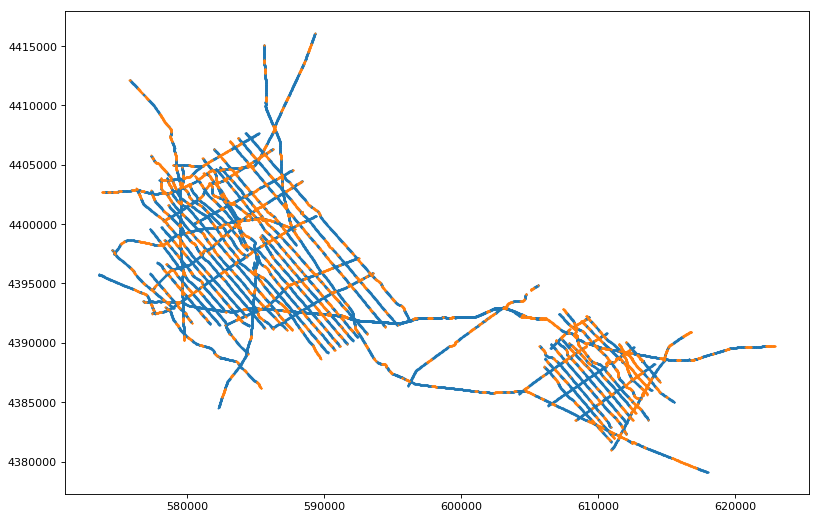

In [73]:
%%time
# for 1 adj sounding and no std, best result was:
# Final ensemble test accuracy of:  87.39 , mean test accuracy of: 84.41 with a std of:  0.61
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(data.loc[data['VALID']==1,'UTMX'],data.loc[data['VALID']==1,'UTMY'],s=0.5)
plt.hold(True)
plt.scatter(data.loc[data['VALID']==0,'UTMX'],data.loc[data['VALID']==0,'UTMY'],s=0.5)

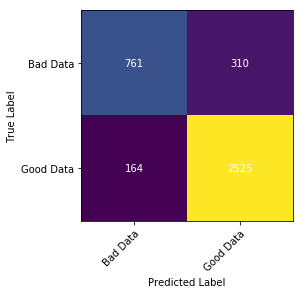

In [22]:
dataClasses = ["Bad Data","Good Data"]


confusionMat = sklearn.metrics.confusion_matrix(Y_test,meanLabels)

fig, ax = plt.subplots()
im = ax.imshow(confusionMat)

# We want to show all ticks...
ax.set_xticks(np.arange(len(dataClasses)))
ax.set_yticks(np.arange(len(dataClasses)))
# ... and label them with the respective list entries
ax.set_xticklabels(dataClasses)
ax.set_yticklabels(dataClasses)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dataClasses)):
    for j in range(len(dataClasses)):
        text = ax.text(j, i, confusionMat[i, j],
                       ha="center", va="center", color="w")

#x.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()  

In [ ]:
# hyper paramater tuning, currently just set up for learning rate, batch size and # of epochs

# values already tried, Feb 19th
#lr_array=np.array([0.1,0.05,0.01,0.005,0.001])
#batch_size_array=np.array([16,32,64,128,256,512,1024])
#epoch_array=np.array([10,20,40,80,160])

# set the arrays Feb 19th, best train acc was at 0.0008 200 450, best test was at 0.0008 160 450
#lr_array=np.array([0.005,0.003,0.001,0.0008,0.0005,0.0001])
#batch_size_array=np.array([400,450,500,512,550])
#epoch_array=np.array([100,130,160,180,200])

# set the arrays, best test acc was 85%, train acc of 97% at 0.0008 250 475 (got to 100% train acc with longer train time, 500 epochs)
lr_array=np.array([0.0009,0.0008,0.0007,0.0006])
batch_size_array=np.array([425,450,475])
epoch_array=np.array([160,170,250,500])


# get their sizes and their final size
lr_array_size=np.shape(lr_array)[0]
batch_size_array_size=np.shape(batch_size_array)[0]
epoch_array_size=np.shape(epoch_array)[0]
final_size=lr_array_size*batch_size_array_size*epoch_array_size

# tile and reshape them
lr_array=np.tile(lr_array,final_size).squeeze()
batch_size_array=np.reshape(np.tile(np.tile(batch_size_array,(lr_array_size,1)).T,(epoch_array_size,1)),[final_size,1]).squeeze()
epoch_array=np.reshape(np.tile(epoch_array,(lr_array_size*batch_size_array_size,1)).T,[1,final_size]).squeeze()

# make lists and arrays for the results
training_history=[]
training_history_acc=np.zeros((final_size,1))
preds_history=[]
preds_loss=np.zeros((final_size,1))
preds_acc=np.zeros((final_size,1))

# loop de loop
for i in range(final_size):
    
    # make the model and its opimizer
    happyModel = model(X_train.shape[1:] )
    adam=keras.optimizers.Adam(beta_1=0.9, beta_2=0.999,lr=lr_array[i])
    
    # compile the model
    happyModel.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])
    
    # fit the model
    temp=happyModel.fit(x = X_train, y = Y_train, epochs = np.int(epoch_array[i]), batch_size = np.int(batch_size_array[i]),  verbose=0)
    
    # store how it did
    training_history_acc[i]=temp.history['acc'][-1]
    training_history.append(temp)
    
    # predict and store on x_test
    temp=happyModel.evaluate(x = X_test, y = Y_test)
    preds_loss[i]=temp[0]
    preds_acc[i]=temp[1]
    preds_history.append(temp)
    
    # print a msg
    print(" Training accuracy = "+str(np.round(training_history_acc[i]*100,2))+"%, learning rate, epoch size, and mini-batch size: "+str(lr_array[i])+","+str(epoch_array[i])+","+str(batch_size_array[i])+", test loss and accuracy: "+str(preds_loss[i])+str(np.round(preds_acc[i]*100,2))+"%")

In [190]:
# current best is lr=0.0008, epochs=250, batch size=475, gives 97.4% train and 85.5% test

[4.456235956638418, 0.7204787234042553]

In [39]:
best=np.argmax(preds_acc)
print(np.max(preds_acc),lr_array[best],epoch_array[best],batch_size_array[best])

0.8550531914893617 0.0008 250 475


In [40]:
best=np.argmax(training_history_acc)
print(np.max(training_history_acc),lr_array[best],epoch_array[best],batch_size_array[best])

1.0 0.0009 500 425


In [96]:
### START CODE HERE ### (1 line)
preds = happyModel.evaluate(x = X_test, y = Y_test)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3680/3760 [============================>.] - ETA: 0s
Loss = 0.4233942541670292
Test Accuracy = 0.8236702127659574


In [23]:
Models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 3, 37, 16)         304       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 3, 18, 16)         0         
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 3, 18, 16)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 3, 18, 32)         7712      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 3, 9, 32)          0         
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 3, 9, 32)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 3, 9, 64)          43072     
__________

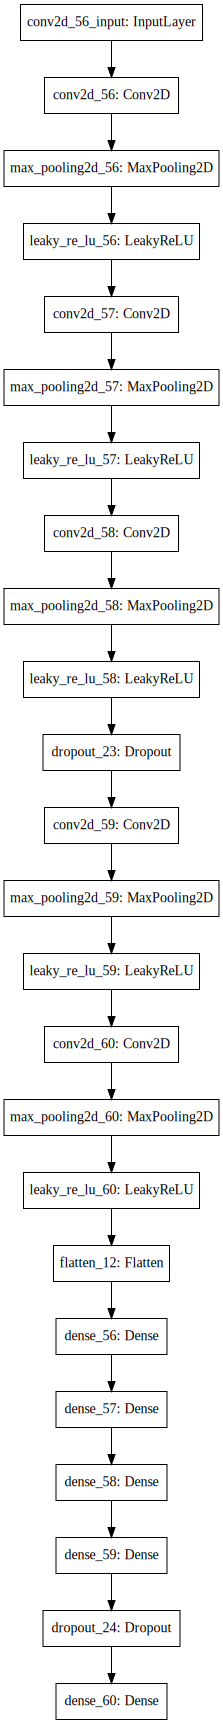

In [24]:
plot_model(Models[0], to_file='Model_graph.png')
SVG(model_to_dot(Models[0]).create(prog='dot', format='svg'))